In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cftime
import calendar
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mticker
from matplotlib.colors import TwoSlopeNorm
import imageio
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

### Reading in the data files

Reading it the different files, then changing the years to normal year and not a proplectic calendar. Also splitting into different seasons in case I need that for later. 

In [2]:
t2m_all_forcing_tes1 = xr.open_dataset('/nird/datalake/NS1004K/elihho/tes0004_echam6_BOT_mm_0_1850_var167.nc')
t2m_all_forcing_slo1 = xr.open_dataset('/nird/datalake/NS1004K/elihho/slo0059_echam6_BOT_mm_0_1850_var167.nc')

tas_orb_GHG = xr.open_dataset('slo0043_echam6_BOT_mm_1001-8850_167_NH.nc')
tas_all_forcing = xr.open_dataset('slo0042+slo0046+slo0050_echam6_BOT_mm_1001_8850_167_NH.nc')
tas_orb_GHG = tas_orb_GHG.sel(time=slice(70010131.994444, 88501231.994444))
tas_all_forcing = tas_all_forcing.sel(time=slice(70010131.994444, 88501231.994444))


In [3]:
#Function to convert time to date time object

#Split up in yyyy, mm and dd lists
def convert_time(time_array):
    #Converting time to pandas dataframe
    time_df = pd.DataFrame(time_array)#-0.99444445

    #Create empty lists
    time = []
    year = []
    month = []
    date = []
    
    #Split up date format in year, month and day
    for i in range(0,len(time_df[0])):
        time.append(str(time_df[0][i]))
        year.append(int(time[i][0:4])-7000)
        month.append(time[i][4:6])
    
    #Add lists to dataframe
    time_df['year']=year
    time_df['month']=month
    #Get the right format (str, yyyy, mm)
    yyyy=time_df['year'].astype("string").str.zfill(4)
    mm=time_df['month'].astype("string")

    #Combine to datestring in format 'yyyy-mm'
    for i in range(0,len(time_df[0])):
        date_stamp = f'{yyyy[i]}-{mm[i]}'
        date.append(date_stamp)

    #Add date string to dataframe
    time_df['date'] = date
    
    #Convert to datetime object. Works from year 0001!
    def convert_to_datetime(date_str):
        try:
            return datetime.strptime(date_str, '%Y-%m')
        except ValueError as e:
            print(f"Error converting date {date_str}: {e}")
            return pd.NaT
    
    # Apply the conversion function to the 'date' column
    time_df['date'] = time_df['date'].apply(convert_to_datetime)
    return time_df['date']

In [4]:
time_t2m_tes = convert_time(t2m_all_forcing_tes1['time'])
time_t2m_slo = convert_time(t2m_all_forcing_slo1['time'])
time_tas_orb_GHG = convert_time(tas_orb_GHG['time'])
time_tas_all_forcing = convert_time(tas_all_forcing['time'])

In [5]:
t2m_tes = t2m_all_forcing_tes1.assign_coords(time = ('time', list(time_t2m_tes)))
t2m_slo = t2m_all_forcing_slo1.assign_coords(time = ('time', list(time_t2m_slo)))
tas_orb_GHG = tas_orb_GHG.assign_coords(time = ('time', list(time_tas_orb_GHG)))
tas_all_forcing = tas_all_forcing.assign_coords(time = ('time', list(time_tas_all_forcing)))

In [6]:
tas_orb_GHG.time

<xarray.DataArray 'time' (time: 22199)> Size: 178kB
array([datetime.datetime(1, 1, 1, 0, 0), datetime.datetime(1, 2, 1, 0, 0),
       datetime.datetime(1, 3, 1, 0, 0), ...,
       datetime.datetime(1850, 9, 1, 0, 0),
       datetime.datetime(1850, 10, 1, 0, 0),
       datetime.datetime(1850, 11, 1, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 178kB 0001-01-01 0001-02-01 ... 1850-10-01 1850-11-01

In [7]:
t2m_tes_tot = t2m_tes.sel(time=slice(datetime(1, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))
t2m_slo_tot = t2m_slo.sel(time=slice(datetime(1, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))

tas_orb_GHG_tot = tas_orb_GHG.sel(time=slice(datetime(1, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))
tas_all_forcing_tot = tas_all_forcing.sel(time=slice(datetime(1, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))

### Global

In [8]:
rolling_years = 20
rolling_months = rolling_years * 12

In [9]:
# Extract latitude
lat = t2m_tes_tot['lat']

# Calculate weights: cos(lat) in radians
weights = np.cos(np.deg2rad(lat))

# Weighted mean
global_mean_tes = t2m_tes_tot['var167'].weighted(weights).mean(dim=['lat', 'lon'])
global_mean_slo = t2m_slo_tot['var167'].weighted(weights).mean(dim=['lat', 'lon'])

# Rolling mean
smoothed_global_mean_tes = global_mean_tes.rolling(time=rolling_months, center=True).mean()
smoothed_global_mean_slo = global_mean_slo.rolling(time=rolling_months, center=True).mean()

In [10]:
orb_GHG = tas_orb_GHG_tot['var167'].weighted(weights).mean(dim=['lat', 'lon'])
all_forcing = tas_all_forcing_tot['var167'].weighted(weights).mean(dim=['lat', 'lon'])

orb_GHG_smooth = orb_GHG.rolling(time=rolling_months, center=True).mean()
all_forcing_smooth = all_forcing.rolling(time=rolling_months, center=True).mean()

### NH

In [11]:
nh_lat = slice(89, 0)

nh_tes = t2m_tes_tot['var167'].sel(lat=nh_lat).weighted(weights).mean(dim=['lat', 'lon'])
nh_slo = t2m_slo_tot['var167'].sel(lat=nh_lat).weighted(weights).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
nh_smoothed_tes = nh_tes.rolling(time=rolling_months, center=True).mean()
nh_smoothed_slo = nh_slo.rolling(time=rolling_months, center=True).mean()

In [12]:
orb_GHG_NH = tas_orb_GHG_tot['var167'].sel(lat=nh_lat).weighted(weights).mean(dim=['lat', 'lon'])
all_forcing_NH = tas_all_forcing_tot['var167'].sel(lat=nh_lat).weighted(weights).mean(dim=['lat', 'lon'])

nh_orb_GHG_smooth = orb_GHG_NH.rolling(time=rolling_months, center=True).mean()
nh_all_forcing_smooth = all_forcing_NH.rolling(time=rolling_months, center=True).mean()

### Scandinvia

In [13]:
scand_lat = slice(71, 55)
scand_lon = slice(5, 30)

scand_tes = t2m_tes_tot['var167'].sel(lat=scand_lat, lon = scand_lon).weighted(weights).mean(dim=['lat', 'lon'])
scand_slo = t2m_slo_tot['var167'].sel(lat=scand_lat, lon = scand_lon).weighted(weights).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
scand_smoothed_tes = scand_tes.rolling(time=rolling_months, center=True).mean()
scand_smoothed_slo = scand_slo.rolling(time=rolling_months, center=True).mean()

In [14]:
scand_orb_GHG = tas_orb_GHG_tot['var167'].sel(lat=scand_lat, lon = scand_lon).weighted(weights).mean(dim=['lat', 'lon'])
scand_all_forcing = tas_all_forcing_tot['var167'].sel(lat=scand_lat, lon = scand_lon).weighted(weights).mean(dim=['lat', 'lon'])

scand_orb_GHG_smooth = scand_orb_GHG.rolling(time=rolling_months, center=True).mean()
scand_all_forcing_smooth = scand_all_forcing.rolling(time=rolling_months, center=True).mean()

### Plotting the different regions from 0-1850 (marking 1250-1750 as LIA)

In [15]:
# Extract decimal years from cftime time coordinate
def cftime_to_decimal_year(time_array):
    years = np.array([t.year for t in time_array])
    months = np.array([t.month for t in time_array])
    # Approximate decimal year (month/12)
    decimal_years = years + (months - 1) / 12
    return decimal_years

x_tes = cftime_to_decimal_year(smoothed_global_mean_tes['time'].values)
x_slo = cftime_to_decimal_year(smoothed_global_mean_slo['time'].values)
x_nh_tes = cftime_to_decimal_year(nh_smoothed_tes['time'].values)
x_nh_slo = cftime_to_decimal_year(nh_smoothed_slo['time'].values)
x_scand_tes = cftime_to_decimal_year(scand_smoothed_tes['time'].values)
x_scand_slo = cftime_to_decimal_year(scand_smoothed_slo['time'].values)

x_orb_GHG = cftime_to_decimal_year(orb_GHG_smooth['time'].values)
x_all_forcing = cftime_to_decimal_year(all_forcing_smooth['time'].values)
x_nh_orb_GHG = cftime_to_decimal_year(nh_orb_GHG_smooth['time'].values)
x_nh_all_forcing = cftime_to_decimal_year(nh_all_forcing_smooth['time'].values)
x_scand_orb_GHG = cftime_to_decimal_year(scand_orb_GHG_smooth['time'].values)
x_scand_all_forcing = cftime_to_decimal_year(scand_all_forcing_smooth['time'].values)

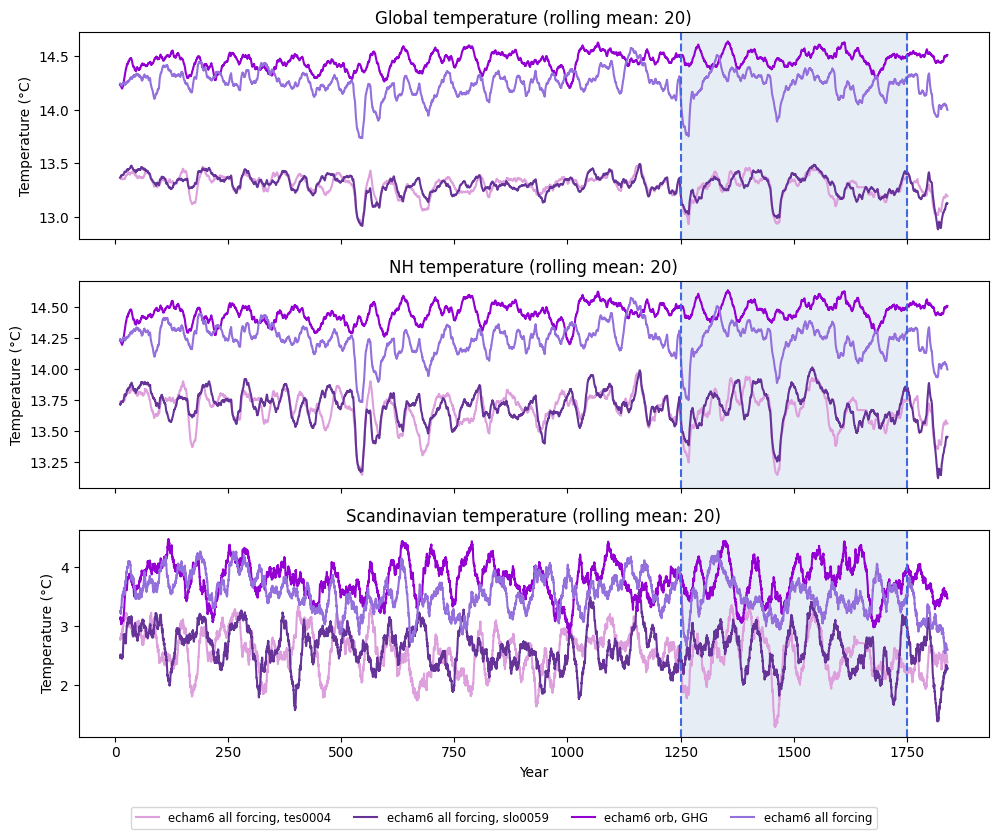

In [16]:
fig, ax = plt.subplots(3,1, figsize=(10,8), sharex = True)

start_time = 1250
end_time = 1750

ax[0].plot(x_tes, smoothed_global_mean_tes - 273.15, color='plum', label='echam6 all forcing, tes0004')
ax[0].plot(x_slo, smoothed_global_mean_slo - 273.15, color='rebeccapurple', label='echam6 all forcing, slo0059')
ax[0].plot(x_orb_GHG, orb_GHG_smooth - 273.15, color='darkviolet', label='echam6 orb, GHG')
ax[0].plot(x_all_forcing, all_forcing_smooth - 273.15, color='mediumpurple', label='echam6 all forcing')
ax[0].axvline(start_time, color='royalblue', linestyle='--')
ax[0].axvline(end_time, color='royalblue', linestyle='--')
ax[0].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title(f'Global temperature (rolling mean: {rolling_years})')

ax[1].plot(x_nh_tes, nh_smoothed_tes - 273.15, color='plum', label='echam6 With Forcing')
ax[1].plot(x_nh_slo, nh_smoothed_slo - 273.15, color='rebeccapurple', label='echam6 W/O Forcing')
ax[1].plot(x_nh_orb_GHG, nh_orb_GHG_smooth - 273.15, color='darkviolet', label='echam6 orb, GHG')
ax[1].plot(x_nh_all_forcing, nh_all_forcing_smooth - 273.15, color='mediumpurple', label='echam6 all forcing')
ax[1].axvline(start_time, color='royalblue', linestyle='--')
ax[1].axvline(end_time, color='royalblue', linestyle='--')
ax[1].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title(f'NH temperature (rolling mean: {rolling_years})')

ax[2].plot(x_scand_tes ,scand_smoothed_tes - 273.15, color='plum', label='echam6 With Forcing')
ax[2].plot(x_scand_slo, scand_smoothed_slo - 273.15, color='rebeccapurple', label='echam6 W/O Forcing')
ax[2].plot(x_scand_orb_GHG, scand_orb_GHG_smooth - 273.15, color='darkviolet', label='echam6 orb, GHG')
ax[2].plot(x_scand_all_forcing, scand_all_forcing_smooth - 273.15, color='mediumpurple', label='echam6 all forcing')
ax[2].axvline(start_time, color='royalblue', linestyle='--')
ax[2].axvline(end_time, color='royalblue', linestyle='--')
ax[2].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Temperature (°C)')
ax[2].set_title(f'Scandinavian temperature (rolling mean: {rolling_years})')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()

## Anomalies of the same thing

### Global

In [17]:
baseline_tes = smoothed_global_mean_tes.mean()
anomaly_tes = smoothed_global_mean_tes - baseline_tes
baseline_slo = smoothed_global_mean_slo.mean()
anomaly_slo = smoothed_global_mean_slo - baseline_slo

baseline_orb_GHG = orb_GHG_smooth.mean()
anomaly_orb_GHG = orb_GHG_smooth - baseline_orb_GHG
baseline_all_forcing = all_forcing_smooth.mean()
anomaly_all_forcing = all_forcing_smooth - baseline_all_forcing

### NH

In [18]:
baseline_nh_tes = nh_smoothed_tes.mean()
anomaly_nh_tes = nh_smoothed_tes - baseline_nh_tes
#smoothed_anomaly_nh_wf = anomaly_nh_wf.rolling(time=rolling_months, center=True).mean()
baseline_nh_slo = nh_smoothed_slo.mean()
anomaly_nh_slo = nh_smoothed_slo - baseline_nh_slo
#smoothed_anomaly_nh_wof = anomaly_nh_wof.rolling(time=rolling_months, center=True).mean()

baseline_nh_orb_GHG = nh_orb_GHG_smooth.mean()
anomaly_nh_orb_GHG = nh_orb_GHG_smooth - baseline_nh_orb_GHG
#smoothed_nh_anomaly_orb_GHG = anomaly_nh_orb_GHG.rolling(time=rolling_months, center=True).mean()
baseline_nh_all_forcing = nh_all_forcing_smooth.mean()
anomaly_nh_all_forcing = nh_all_forcing_smooth - baseline_nh_all_forcing
#smoothed_nh_anomaly_all_forcing = anomaly_nh_all_forcing.rolling(time=rolling_months, center=True).mean()

### Scandinavia

In [19]:
baseline_scand_tes = scand_smoothed_tes.mean()
anomaly_scand_tes = scand_smoothed_tes - baseline_scand_tes
#smoothed_anomaly_scand_wf = anomaly_scand_wf.rolling(time=rolling_months, center=True).mean()
baseline_scand_slo = scand_smoothed_slo.mean()
anomaly_scand_slo = scand_smoothed_slo - baseline_scand_slo
#smoothed_anomaly_scand_wof = anomaly_scand_wof.rolling(time=rolling_months, center=True).mean()

baseline_scand_orb_GHG = scand_orb_GHG_smooth.mean()
anomaly_scand_orb_GHG = scand_orb_GHG_smooth - baseline_scand_orb_GHG
#smoothed_scand_anomaly_orb_GHG = anomaly_scand_orb_GHG.rolling(time=rolling_months, center=True).mean()
baseline_scand_all_forcing = scand_all_forcing_smooth.mean()
anomaly_scand_all_forcing = scand_all_forcing_smooth - baseline_scand_all_forcing
#smoothed_scand_anomaly_all_forcing = anomaly_scand_all_forcing.rolling(time=rolling_months, center=True).mean()

### Plot

In [20]:
x_wf = cftime_to_decimal_year(anomaly_tes['time'].values)
x_wof = cftime_to_decimal_year(anomaly_slo['time'].values)
x_nh_wf = cftime_to_decimal_year(anomaly_nh_tes['time'].values)
x_nh_wof = cftime_to_decimal_year(anomaly_nh_slo['time'].values)
x_scand_wf = cftime_to_decimal_year(anomaly_scand_tes['time'].values)
x_scand_wof = cftime_to_decimal_year(anomaly_scand_slo['time'].values)

x_orb_GHG = cftime_to_decimal_year(anomaly_orb_GHG['time'].values)
x_all_forcing = cftime_to_decimal_year(anomaly_all_forcing['time'].values)
x_nh_orb_GHG = cftime_to_decimal_year(anomaly_nh_orb_GHG['time'].values)
x_nh_all_forcing = cftime_to_decimal_year(anomaly_nh_all_forcing['time'].values)
x_scand_orb_GHG = cftime_to_decimal_year(anomaly_scand_orb_GHG['time'].values)
x_scand_all_forcing = cftime_to_decimal_year(anomaly_scand_all_forcing['time'].values)

In [21]:
start_time = 1250
end_time = 1850

mask_tes = (x_tes >= start_time) & (x_tes <= end_time)
mask_slo = (x_slo >= start_time) & (x_slo <= end_time)
mask_all = (x_all_forcing >= start_time) & (x_all_forcing <= end_time)

global_means = [
    np.mean(anomaly_tes[mask_tes]),
    np.mean(anomaly_slo[mask_slo]),
    np.mean(anomaly_all_forcing[mask_all])
]

mean_global_LIA = np.mean(global_means)

mask_nh_tes = (x_nh_tes >= start_time) & (x_nh_tes <= end_time)
mask_nh_slo = (x_nh_slo >= start_time) & (x_nh_slo <= end_time)
mask_nh_all = (x_nh_all_forcing >= start_time) & (x_nh_all_forcing <= end_time)
nh_means = [
    np.mean(anomaly_nh_tes[mask_nh_tes]),
    np.mean(anomaly_nh_slo[mask_nh_slo]),
    np.mean(anomaly_nh_all_forcing[mask_nh_all])
]

mean_nh_LIA = np.mean(nh_means)

mask_scand_tes = (x_scand_tes >= start_time) & (x_scand_tes <= end_time)
mask_scand_slo = (x_scand_slo >= start_time) & (x_scand_slo <= end_time)
mask_scand_all = (x_scand_all_forcing >= start_time) & (x_scand_all_forcing <= end_time)

scand_means = [
    np.mean(anomaly_scand_tes[mask_scand_tes]),
    np.mean(anomaly_scand_slo[mask_scand_slo]),
    np.mean(anomaly_scand_all_forcing[mask_scand_all])
]

mean_scand_LIA = np.mean(scand_means)

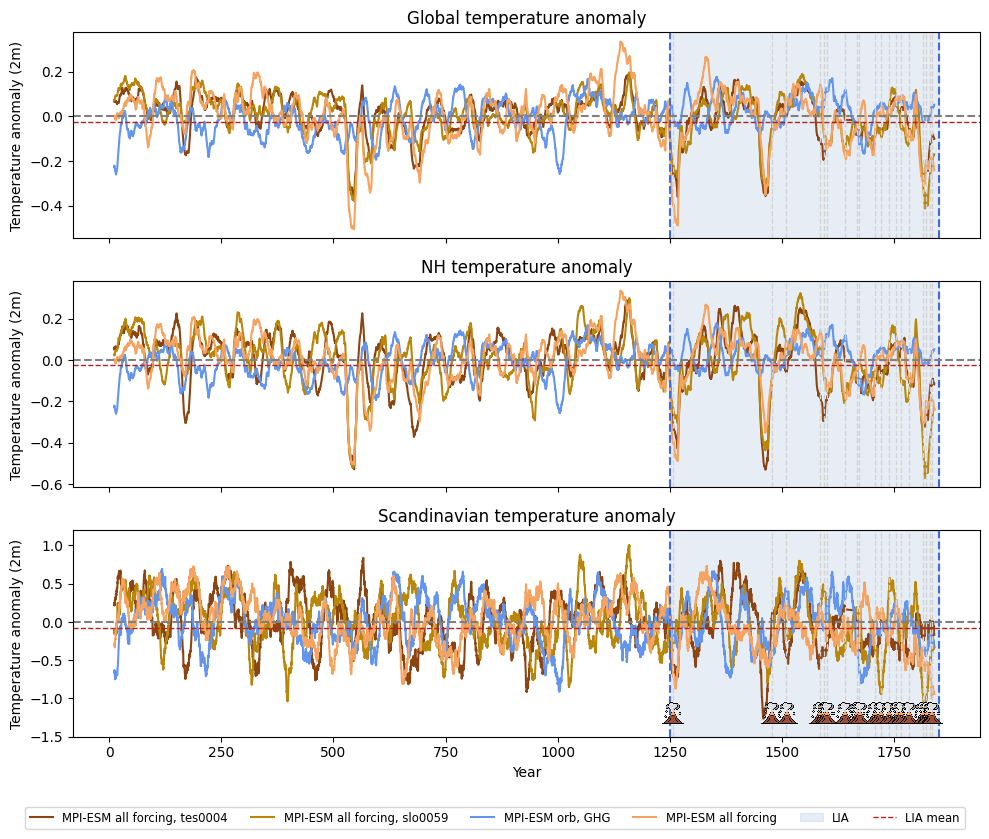

In [22]:
volcano = [1257, 1477, 1510, 1585, 1595, 1600, 1640, 1667, 1673, 1707, 1721, 1739, 1755, 1766, 1783, 1815, 1822, 1831, 1835]

volcano_img = mpimg.imread("volcano.png") 
volcano_icon = OffsetImage(volcano_img, zoom=0.03)

fig, ax = plt.subplots(3,1, figsize=(10,8), sharex = True)

start_time = 1250
end_time = 1850

ax[0].plot(x_tes, anomaly_tes, color='saddlebrown', label='MPI-ESM all forcing, tes0004')
ax[0].plot(x_slo, anomaly_slo, color='darkgoldenrod', label='MPI-ESM all forcing, slo0059')
ax[0].plot(x_orb_GHG, anomaly_orb_GHG, color='cornflowerblue', label='MPI-ESM orb, GHG')
ax[0].plot(x_all_forcing, anomaly_all_forcing, color='sandybrown', label='MPI-ESM all forcing')
for vt in volcano:
    ax[0].axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
ax[0].axvline(start_time, color='royalblue', linestyle='--')
ax[0].axvline(end_time, color='royalblue', linestyle='--')
ax[0].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3, label='LIA')
ax[0].axhline(0, linestyle='--', color='gray')
ax[0].axhline(mean_global_LIA, color='firebrick', linestyle='--', linewidth=1,
              label=f'LIA mean')
ax[0].set_ylabel('Temperature anomaly (2m)')
ax[0].set_title(f'Global temperature anomaly')

ax[1].plot(x_nh_tes, anomaly_nh_tes, color='saddlebrown', label='MPI-ESM all forcing, tes0004')
ax[1].plot(x_nh_slo, anomaly_nh_slo, color='darkgoldenrod', label='MPI-ESM all forcing, slo0059')
ax[1].plot(x_nh_orb_GHG, anomaly_nh_orb_GHG, color='cornflowerblue', label='MPI-ESM orb, GHG')
ax[1].plot(x_nh_all_forcing, anomaly_nh_all_forcing, color='sandybrown', label='MPI-ESM all forcing')
for vt in volcano:
    ax[1].axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
ax[1].axvline(start_time, color='royalblue', linestyle='--')
ax[1].axvline(end_time, color='royalblue', linestyle='--')
ax[1].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[1].axhline(mean_nh_LIA, color='firebrick', linestyle='--', linewidth=1,
              label=f'LIA mean')
ax[1].axhline(0, linestyle='--', color='gray')
ax[1].set_ylabel('Temperature anomaly (2m)')
ax[1].set_title(f'NH temperature anomaly')

ax[2].plot(x_scand_tes, anomaly_scand_tes, color='saddlebrown', label='MPI-ESM all forcing, tes0004')
ax[2].plot(x_scand_slo, anomaly_scand_slo, color='darkgoldenrod', label='MPI-ESM all forcing, slo0059')
ax[2].plot(x_scand_orb_GHG, anomaly_scand_orb_GHG, color='cornflowerblue', label='MPI-ESM orb, GHG')
ax[2].plot(x_scand_all_forcing, anomaly_scand_all_forcing, color='sandybrown', label='MPI-ESM all forcing')
for vt in volcano:
    ax[2].axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
    ab = AnnotationBbox(volcano_icon, (vt, -1.2), frameon=False, box_alignment=(0.5, 0.5))
    ax[2].add_artist(ab)
ax[2].axvline(start_time, color='royalblue', linestyle='--')
ax[2].axvline(end_time, color='royalblue', linestyle='--')
ax[2].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[2].axhline(0, linestyle='--', color='gray')
ax[2].axhline(mean_scand_LIA, color='firebrick', linestyle='--', linewidth=1,
              label=f'LIA mean')
ax[2].set_ylim(-1.5, 1.2)
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Temperature anomaly (2m)')
ax[2].set_title(f'Scandinavian temperature anomaly')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Climate model: Scandinavian temperature anomaly')

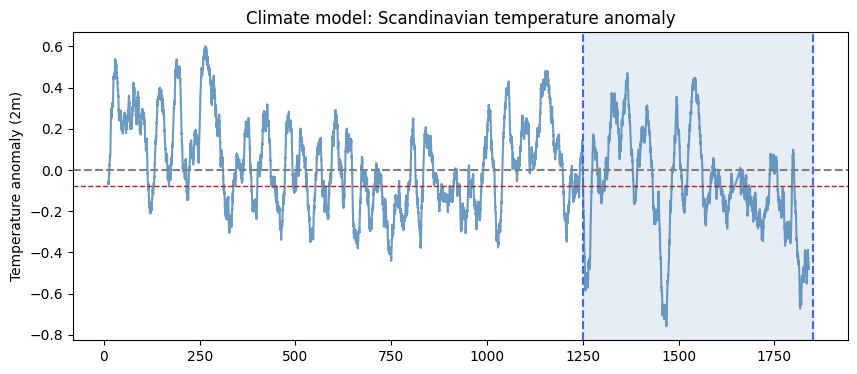

In [23]:
mean_anomaly = (anomaly_scand_all_forcing + anomaly_scand_slo + anomaly_scand_tes)/3
x_mean = cftime_to_decimal_year(mean_anomaly['time'].values)

fig, ax = plt.subplots(1,1, figsize=(10,4))

start_time = 1250
end_time = 1850

#ax.plot(x_scand_tes, anomaly_scand_tes, color='saddlebrown', label='MPI-ESM all forcing, tes0004')
#ax.plot(x_scand_slo, anomaly_scand_slo, color='darkgoldenrod', label='MPI-ESM all forcing, slo0059')
#ax.plot(x_scand_all_forcing, anomaly_scand_all_forcing, color='sandybrown', label='MPI-ESM all forcing')
ax.plot(x_mean, mean_anomaly, color='steelblue', alpha=0.8, label='MPI-ESM all forcing')
ax.axvline(start_time, color='royalblue', linestyle='--')
ax.axvline(end_time, color='royalblue', linestyle='--')
ax.axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3, label='LIA')
ax.axhline(0, linestyle='--', color='gray')
ax.axhline(mean_scand_LIA, color='firebrick', linestyle='--', linewidth=1,
              label=f'LIA mean')
ax.set_ylabel('Temperature anomaly (2m)')
ax.set_title(f'Climate model: Scandinavian temperature anomaly')

In [24]:
aod = xr.open_dataset('/nird/datalake/NS1004K/elihho/eVolv2k_v3_EVA_AOD_-500_1900_1_ym.nc')

lat = aod['lat']
weights = np.cos(np.deg2rad(lat))

scand_aod = aod['aod550'].sel(lat=scand_lat).weighted(weights).mean(dim='lat')

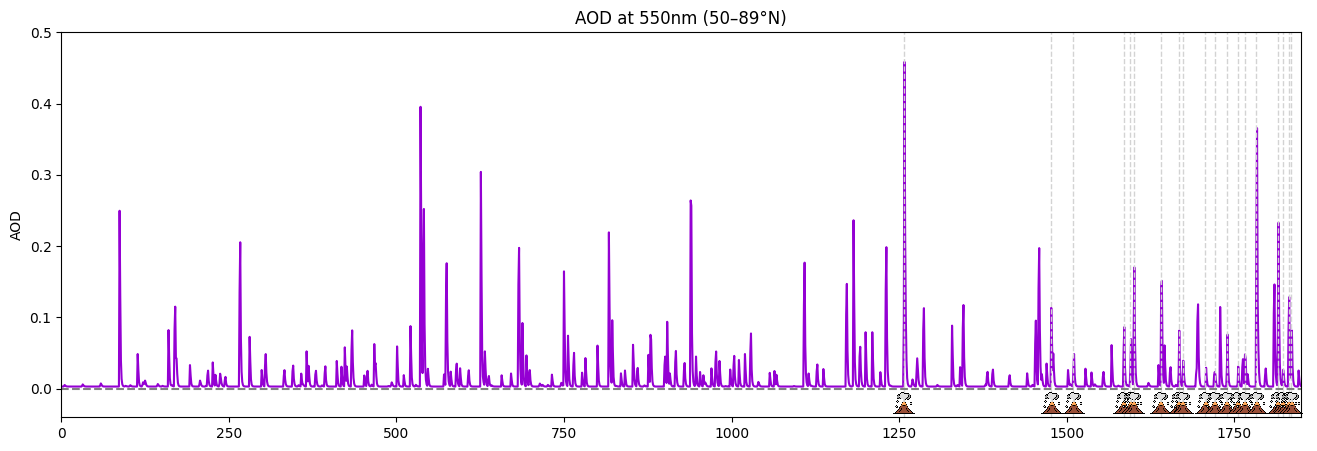

In [25]:
scand_aod_1250_1850 = scand_aod.sel(time = slice(0., 1850.))

volcano = [1257, 1477, 1510, 1585, 1595, 1600, 1640, 1667, 1673, 1707, 1721, 1739, 1755, 1766, 1783, 1815, 1822, 1831, 1835]

volcano_img = mpimg.imread("volcano.png") 
volcano_icon = OffsetImage(volcano_img, zoom=0.03)

fig, ax = plt.subplots(figsize=(16,5))

x = scand_aod_1250_1850['time'].values
y = scand_aod_1250_1850.values
ax.plot(x, y, color='darkviolet', label='echam6 all forcing')

for vt in volcano:
    ax.axvline(vt, color='lightgray', linestyle='--', linewidth=1)
    ab = AnnotationBbox(volcano_icon, (vt, -0.02), frameon=False, box_alignment=(0.5, 0.5))
    ax.add_artist(ab)

ax.axhline(0, linestyle='--', color='gray')
ax.set_ylim(-0.04, 0.5)
ax.set_xlim(0, 1850)
ax.set_ylabel('AOD')
ax.set_title('AOD at 550nm (50–89°N)')
plt.show()

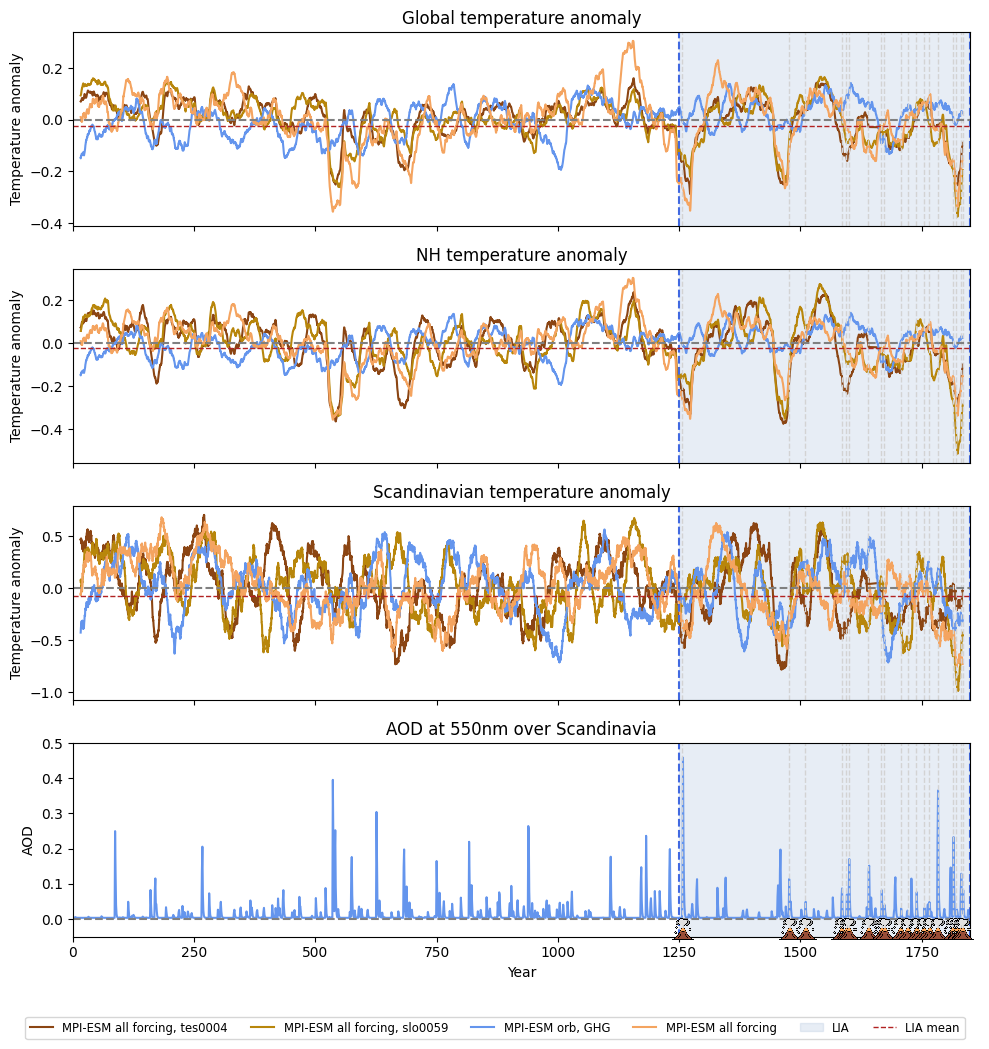

In [26]:
volcano = [1257, 1477, 1510, 1585, 1595, 1600, 1640, 1667, 1673, 1707, 1721, 1739, 1755, 1766, 1783, 1815, 1822, 1831, 1835]

volcano_img = mpimg.imread("volcano.png") 
volcano_icon = OffsetImage(volcano_img, zoom=0.03)

fig, ax = plt.subplots(4,1, figsize=(10,10), sharex = True)

start_time = 1250
end_time = 1850

ax[0].plot(x_tes, anomaly_tes, color='saddlebrown', label='MPI-ESM all forcing, tes0004')
ax[0].plot(x_slo, anomaly_slo, color='darkgoldenrod', label='MPI-ESM all forcing, slo0059')
ax[0].plot(x_orb_GHG, anomaly_orb_GHG, color='cornflowerblue', label='MPI-ESM orb, GHG')
ax[0].plot(x_all_forcing, anomaly_all_forcing, color='sandybrown', label='MPI-ESM all forcing')
for vt in volcano:
    ax[0].axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
ax[0].axvline(start_time, color='royalblue', linestyle='--')
ax[0].axvline(end_time, color='royalblue', linestyle='--')
ax[0].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3, label='LIA')
ax[0].axhline(0, linestyle='--', color='gray')
ax[0].axhline(mean_global_LIA, color='firebrick', linestyle='--', linewidth=1,
              label=f'LIA mean')
ax[0].set_ylabel('Temperature anomaly')
ax[0].set_title(f'Global temperature anomaly')

ax[1].plot(x_nh_tes, anomaly_nh_tes, color='saddlebrown', label='MPI-ESM all forcing, tes0004')
ax[1].plot(x_nh_slo, anomaly_nh_slo, color='darkgoldenrod', label='MPI-ESM all forcing, slo0059')
ax[1].plot(x_nh_orb_GHG, anomaly_nh_orb_GHG, color='cornflowerblue', label='MPI-ESM orb, GHG')
ax[1].plot(x_nh_all_forcing, anomaly_nh_all_forcing, color='sandybrown', label='MPI-ESM all forcing')
for vt in volcano:
    ax[1].axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
ax[1].axvline(start_time, color='royalblue', linestyle='--')
ax[1].axvline(end_time, color='royalblue', linestyle='--')
ax[1].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[1].axhline(mean_nh_LIA, color='firebrick', linestyle='--', linewidth=1,
              label=f'LIA mean')
ax[1].axhline(0, linestyle='--', color='gray')
ax[1].set_ylabel('Temperature anomaly')
ax[1].set_title(f'NH temperature anomaly')

ax[2].plot(x_scand_tes, anomaly_scand_tes, color='saddlebrown', label='MPI-ESM all forcing, tes0004')
ax[2].plot(x_scand_slo, anomaly_scand_slo, color='darkgoldenrod', label='MPI-ESM all forcing, slo0059')
ax[2].plot(x_scand_orb_GHG, anomaly_scand_orb_GHG, color='cornflowerblue', label='MPI-ESM orb, GHG')
ax[2].plot(x_scand_all_forcing, anomaly_scand_all_forcing, color='sandybrown', label='MPI-ESM all forcing')
for vt in volcano:
    ax[2].axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
ax[2].axvline(start_time, color='royalblue', linestyle='--')
ax[2].axvline(end_time, color='royalblue', linestyle='--')
ax[2].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[2].axhline(0, linestyle='--', color='gray')
ax[2].axhline(mean_scand_LIA, color='firebrick', linestyle='--', linewidth=1,
              label=f'LIA mean')

ax[2].set_ylabel('Temperature anomaly')
ax[2].set_title(f'Scandinavian temperature anomaly')

x = scand_aod_1250_1850['time'].values
y = scand_aod_1250_1850.values
ax[3].plot(x, y, color='cornflowerblue', label='echam6 all forcing')
for vt in volcano:
    ax[3].axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
    ab = AnnotationBbox(volcano_icon, (vt, -0.03), frameon=False, box_alignment=(0.5, 0.5))
    ax[3].add_artist(ab)
ax[3].axhline(0, linestyle='--', color='gray')
ax[3].axvline(start_time, color='royalblue', linestyle='--')
ax[3].axvline(end_time, color='royalblue', linestyle='--')
ax[3].axvspan(start_time, end_time, color='lightsteelblue', alpha=0.3)
ax[3].set_ylim(-0.05, 0.5)
ax[3].set_xlim(0, 1850)
ax[3].set_ylabel('AOD')
ax[3].set_xlabel('Year')
ax[3].set_title('AOD at 550nm over Scandinavia')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()

## Zoomed into LIA (1250-1750)

In [27]:
t2m_tes_lia = t2m_tes.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))
t2m_slo_lia = t2m_slo.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))

tas_orb_GHG_lia = tas_orb_GHG.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))
tas_all_forcing_lia = tas_all_forcing.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))

In [28]:
# Simple average
global_mean_lia_tes = t2m_tes_lia['var167'].mean(dim=['lat', 'lon'])
global_mean_lia_slo = t2m_slo_lia['var167'].mean(dim=['lat', 'lon'])

rolling_years = 10
rolling_months = rolling_years * 12

smoothed_global_mean_tes = global_mean_lia_tes.rolling(time=rolling_months, center=True).mean()
smoothed_global_mean_slo = global_mean_lia_slo.rolling(time=rolling_months, center=True).mean()

In [29]:
nh_lia_tes = t2m_tes_lia['var167'].sel(lat=nh_lat).mean(dim=['lat', 'lon'])
nh_lia_slo = t2m_slo_lia['var167'].sel(lat=nh_lat).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
nh_smoothed_tes = nh_lia_tes.rolling(time=rolling_months, center=True).mean()
nh_smoothed_slo = nh_lia_slo.rolling(time=rolling_months, center=True).mean()

In [30]:
scand_lia_tes = t2m_tes_lia['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])
scand_lia_slo = t2m_slo_lia['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
scand_smoothed_tes = scand_lia_tes.rolling(time=rolling_months, center=True).mean()
scand_smoothed_slo = scand_lia_slo.rolling(time=rolling_months, center=True).mean()

In [31]:
orb_GHG_lia = tas_orb_GHG_lia['var167'].mean(dim=['lat', 'lon'])
all_forcing_lia = tas_all_forcing_lia['var167'].mean(dim=['lat', 'lon'])

orb_GHG_smooth = orb_GHG_lia.rolling(time=rolling_months, center=True).mean()
all_forcing_smooth = all_forcing_lia.rolling(time=rolling_months, center=True).mean()

In [32]:
nh_orb_GHG_lia = tas_orb_GHG_lia['var167'].sel(lat=nh_lat).mean(dim=['lat', 'lon'])
nh_all_forcing_lia = tas_all_forcing_lia['var167'].sel(lat=nh_lat).mean(dim=['lat', 'lon'])

nh_orb_GHG_smooth = nh_orb_GHG_lia.rolling(time=rolling_months, center=True).mean()
nh_all_forcing_smooth = nh_all_forcing_lia.rolling(time=rolling_months, center=True).mean()

In [33]:
scand_orb_GHG_lia = tas_orb_GHG_lia['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])
scand_all_forcing_lia = tas_all_forcing_lia['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])

scand_orb_GHG_smooth = scand_orb_GHG_lia.rolling(time=rolling_months, center=True).mean()
scand_all_forcing_smooth = scand_all_forcing_lia.rolling(time=rolling_months, center=True).mean()

In [34]:
ref_mean_tes = smoothed_global_mean_tes.mean()
ref_mean_slo = smoothed_global_mean_slo.mean()
ref_mean_orb_GHG = orb_GHG_smooth.mean()
ref_mean_all = all_forcing_smooth.mean()

ref_mean_nh_tes = nh_smoothed_tes.mean()
ref_mean_nh_slo = nh_smoothed_slo.mean()
ref_mean_nh_orb_GHG = nh_orb_GHG_smooth.mean()
ref_mean_nh_all = nh_all_forcing_smooth.mean()

ref_mean_scand_tes = scand_smoothed_tes.mean()
ref_mean_scand_slo = scand_smoothed_slo.mean()
ref_mean_scand_orb_GHG = scand_orb_GHG_smooth.mean()
ref_mean_scand_all = scand_all_forcing_smooth.mean()

In [35]:
anomaly_tes= smoothed_global_mean_tes - ref_mean_tes
anomaly_slo = smoothed_global_mean_slo - ref_mean_slo
anomaly_orb_GHG = orb_GHG_smooth - ref_mean_orb_GHG 
anomaly_all = all_forcing_smooth - ref_mean_all

anomaly_nh_tes = nh_smoothed_tes - ref_mean_nh_tes
anomaly_nh_slo = nh_smoothed_slo - ref_mean_nh_slo
anomaly_nh_orb_GHG = nh_orb_GHG_smooth - ref_mean_orb_GHG 
anomaly_nh_all = nh_all_forcing_smooth - ref_mean_all

anomaly_scand_tes = scand_smoothed_tes - ref_mean_scand_tes
anomaly_scand_slo = scand_smoothed_slo - ref_mean_scand_slo
anomaly_scand_orb_GHG = scand_orb_GHG_smooth - ref_mean_scand_orb_GHG 
anomaly_scand_all = scand_all_forcing_smooth - ref_mean_scand_all

In [36]:
x_tes = cftime_to_decimal_year(anomaly_tes['time'].values)
x_slo = cftime_to_decimal_year(anomaly_slo['time'].values)
x_nh_tes = cftime_to_decimal_year(anomaly_nh_tes['time'].values)
x_nh_slo = cftime_to_decimal_year(anomaly_nh_slo['time'].values)
x_scand_tes = cftime_to_decimal_year(anomaly_scand_tes['time'].values)
x_scand_slo = cftime_to_decimal_year(anomaly_scand_slo['time'].values)

x_orb_GHG = cftime_to_decimal_year(anomaly_orb_GHG['time'].values)
x_all_forcing = cftime_to_decimal_year(anomaly_all['time'].values)
x_nh_orb_GHG = cftime_to_decimal_year(anomaly_nh_orb_GHG['time'].values)
x_nh_all_forcing = cftime_to_decimal_year(anomaly_nh_all['time'].values)
x_scand_orb_GHG = cftime_to_decimal_year(anomaly_scand_orb_GHG['time'].values)
x_scand_all_forcing = cftime_to_decimal_year(anomaly_scand_all['time'].values)

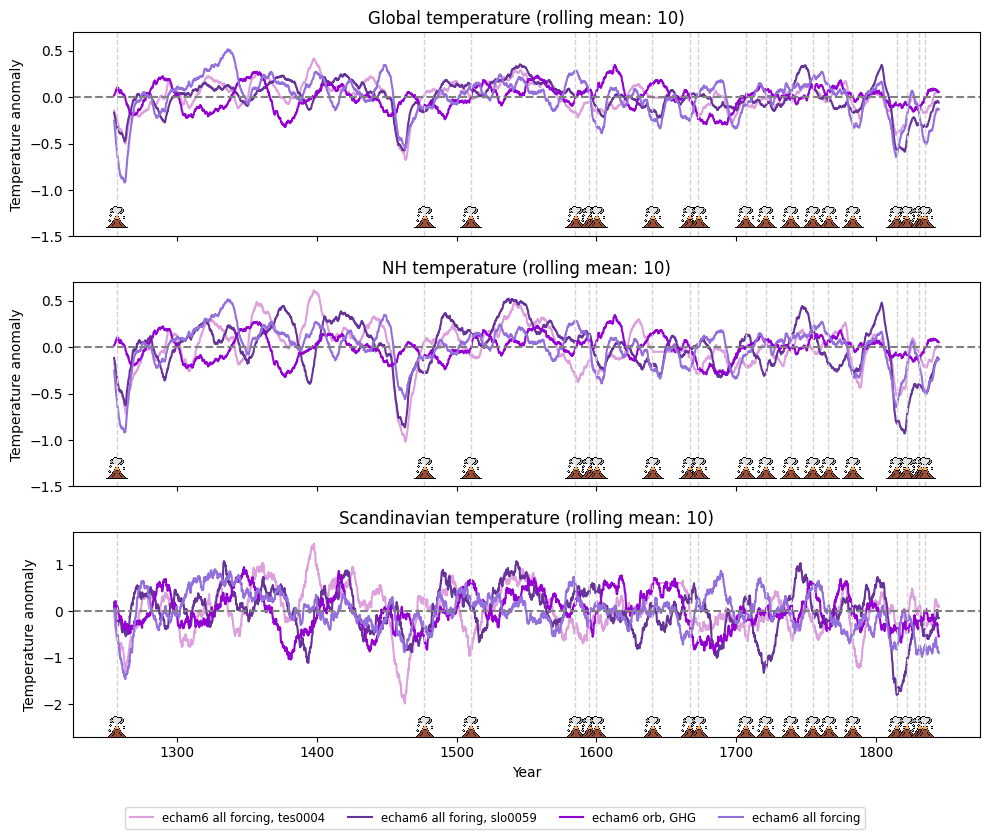

In [37]:
volcano = [1257, 1477, 1510, 1585, 1595, 1600, 1640, 1667, 1673, 1707, 1721, 1739, 1755, 1766, 1783, 1815, 1822, 1831, 1835]

volcano_img = mpimg.imread("volcano.png") 
volcano_icon = OffsetImage(volcano_img, zoom=0.03)

fig, ax = plt.subplots(3,1, figsize=(10,8), sharex = True)

start_time = 1250
end_time = 1750

ax[0].plot(x_tes, anomaly_tes, color='plum', label='echam6 all forcing, tes0004')
ax[0].plot(x_slo, anomaly_slo, color='rebeccapurple', label='echam6 all foring, slo0059')
ax[0].plot(x_orb_GHG, anomaly_orb_GHG, color='darkviolet', label='echam6 orb, GHG')
ax[0].plot(x_all_forcing, anomaly_all, color='mediumpurple', label='echam6 all forcing')
for vt in volcano:
    ax[0].axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
    ab = AnnotationBbox(volcano_icon, (vt, -1.3), frameon=False, box_alignment=(0.5, 0.5))
    ax[0].add_artist(ab)
ax[0].axhline(0, linestyle='--', color='gray')
ax[0].set_ylim(-1.5, 0.7)
ax[0].set_ylabel('Temperature anomaly')
ax[0].set_title(f'Global temperature (rolling mean: {rolling_years})')

ax[1].plot(x_nh_tes, anomaly_nh_tes, color='plum', label='echam6 With Forcing')
ax[1].plot(x_nh_slo, anomaly_nh_slo, color='rebeccapurple', label='echam6 W/O Forcing')
ax[1].plot(x_nh_orb_GHG, anomaly_nh_orb_GHG, color='darkviolet', label='echam6 orb, GHG')
ax[1].plot(x_nh_all_forcing, anomaly_nh_all, color='mediumpurple', label='echam6 all forcing')
for vt in volcano:
    ax[1].axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
    ab = AnnotationBbox(volcano_icon, (vt, -1.3), frameon=False, box_alignment=(0.5, 0.5))
    ax[1].add_artist(ab)
ax[1].axhline(0, linestyle='--', color='gray')
ax[1].set_ylim(-1.5, 0.7)
ax[1].set_ylabel('Temperature anomaly')
ax[1].set_title(f'NH temperature (rolling mean: {rolling_years})')

ax[2].plot(x_scand_tes, anomaly_scand_tes, color='plum', label='echam6 With Forcing')
ax[2].plot(x_scand_slo, anomaly_scand_slo, color='rebeccapurple', label='echam6 W/O Forcing')
ax[2].plot(x_scand_orb_GHG, anomaly_scand_orb_GHG, color='darkviolet', label='echam6 orb, GHG')
ax[2].plot(x_scand_all_forcing, anomaly_scand_all, color='mediumpurple', label='echam6 all forcing')
for vt in volcano:
    ax[2].axvline(x=vt, color='lightgray', linestyle='--', linewidth=1)
    ab = AnnotationBbox(volcano_icon, (vt, -2.5), frameon=False, box_alignment=(0.5, 0.5))
    ax[2].add_artist(ab)
ax[2].axhline(0, linestyle='--', color='gray')
ax[2].set_ylim(-2.7, 1.7)
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Temperature anomaly')
ax[2].set_title(f'Scandinavian temperature (rolling mean: {rolling_years})')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()

## LAKI

In [38]:
rolling_years = 1
rolling_months = rolling_years * 12

In [39]:
t2m_tes_laki = t2m_tes.sel(time=slice(datetime(1782, 1, 1, 0, 0), datetime(1792, 12, 1, 0, 0)))
t2m_slo_laki = t2m_slo.sel(time=slice(datetime(1782, 1, 1, 0, 0), datetime(1792, 12, 1, 0, 0)))
tas_orb_GHG_laki = tas_orb_GHG.sel(time=slice(datetime(1782, 1, 1, 0, 0), datetime(1792, 12, 1, 0, 0)))
tas_all_forcing_laki = tas_all_forcing.sel(time=slice(datetime(1782, 1, 1, 0, 0), datetime(1792, 12, 1, 0, 0)))

In [40]:
scand_laki_tes = t2m_tes_laki['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])
scand_laki_slo = t2m_slo_laki['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])

scand_smoothed_tes_laki = scand_laki_tes.rolling(time=rolling_months, center=True).mean()
scand_smoothed_slo_laki = scand_laki_slo.rolling(time=rolling_months, center=True).mean()

In [41]:
scand_orb_GHG_laki = tas_orb_GHG_laki['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])
scand_all_forcing_laki = tas_all_forcing_laki['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])

scand_orb_GHG_smooth_laki = scand_orb_GHG_laki.rolling(time=rolling_months, center=True).mean()
scand_all_forcing_smooth_laki = scand_all_forcing_laki.rolling(time=rolling_months, center=True).mean()

In [42]:
ref_mean_scand_tes = scand_smoothed_tes.mean()
ref_mean_scand_slo = scand_smoothed_slo.mean()
ref_mean_scand_orb_GHG = scand_orb_GHG_smooth.mean()
ref_mean_scand_all = scand_all_forcing_smooth.mean()

In [43]:
anomaly_scand_tes_laki = scand_smoothed_tes_laki - ref_mean_scand_tes
anomaly_scand_slo_laki = scand_smoothed_slo_laki - ref_mean_scand_slo
anomaly_scand_orb_GHG_laki = scand_orb_GHG_smooth_laki - ref_mean_scand_orb_GHG 
anomaly_scand_all_laki = scand_all_forcing_smooth_laki - ref_mean_scand_all

In [44]:
x_scand_tes = cftime_to_decimal_year(anomaly_scand_tes_laki['time'].values)
x_scand_slo = cftime_to_decimal_year(anomaly_scand_slo_laki['time'].values)
x_scand_orb_GHG = cftime_to_decimal_year(anomaly_scand_orb_GHG_laki['time'].values)
x_scand_all_forcing = cftime_to_decimal_year(anomaly_scand_all_laki['time'].values)

In [45]:
def remove_duplicate_times(da):
    _, index = np.unique(da['time'], return_index=True)
    return da.isel(time=index)
anomaly_scand_tes = remove_duplicate_times(anomaly_scand_tes)
anomaly_scand_slo = remove_duplicate_times(anomaly_scand_slo)
anomaly_scand_all = remove_duplicate_times(anomaly_scand_all)

baseline_stack = xr.concat(
    [anomaly_scand_tes, anomaly_scand_slo, anomaly_scand_all],
    dim=pd.Index(['tes', 'slo', 'all'], name='run')
)
shared_mean = baseline_stack.mean(dim=['run', 'time'])
shared_std = baseline_stack.std(dim=['run', 'time'])

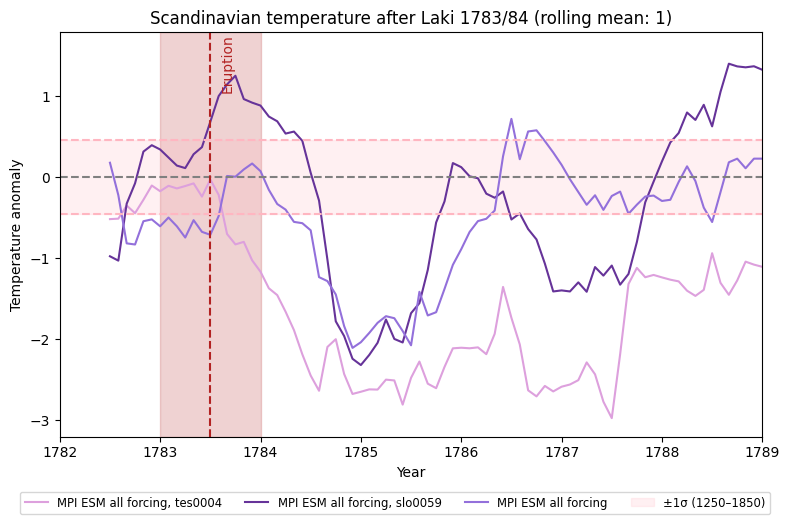

In [46]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

ax.plot(x_scand_tes, anomaly_scand_tes_laki, color='plum', label='MPI ESM all forcing, tes0004')
ax.plot(x_scand_slo, anomaly_scand_slo_laki, color='rebeccapurple', label='MPI ESM all forcing, slo0059')
ax.plot(x_scand_all_forcing, anomaly_scand_all_laki, color='mediumpurple', label='MPI ESM all forcing')

ax.axhline(0, linestyle='--', color='gray')
ax.axvline(1783.5, linestyle='--', color='firebrick')
ax.text(1783.6, ax.get_ylim()[1]*0.6, 'Eruption', rotation=90, color='firebrick')
ax.axvspan(1783, 1784, color='firebrick', alpha=0.2)
# Add ±1σ shaded area
ax.axhline(shared_std, linestyle='--', color='lightpink')
ax.axhline(-shared_std, linestyle='--', color='lightpink')
ax.fill_between(
    x_scand_tes,
    shared_mean - shared_std,
    shared_mean + shared_std,
    color='lightpink',
    alpha=0.2,
    label='±1σ (1250–1850)'
)

ax.set_xlim(1782, 1789)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature anomaly')
ax.set_title(f'Scandinavian temperature after Laki 1783/84 (rolling mean: {rolling_years})')

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=4,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()